### Figure 4for Siddiqui et al 

In [1]:
import oceanspy as ospy
import xarray as xr
import matplotlib.pyplot as plt 
import cmocean
import cartopy.crs as ccrs
import numpy as np
import xarray as xr

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': '28',
         'axes.titlesize':'28',
         'xtick.labelsize':'28',
         'ytick.labelsize':'28'}
pylab.rcParams.update(params)

In [3]:
from matplotlib.patches import Polygon
%matplotlib inline

import warnings

import matplotlib.path                 as mpath
import cartopy.crs                     as ccrs
import cartopy.mpl.ticker              as ctk
import cartopy.feature as cfeature
import cartopy.mpl.patch as cpatch
import matplotlib as mpl

In [4]:
pylab.rcParams.update({
  "text.usetex": True
})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [5]:
data_dir = '/home/idies/workspace/Storage/asiddi24/persistent/SciServer/Chapter_1/Siddiqui_etal_JGR_2023/data/'

f1_trend_ecco = xr.open_dataset(data_dir+'ecco_f1trend.nc')
f1_trend_en4 = xr.open_dataset(data_dir+'en4_f1trend.nc')

f2_trend_ecco = xr.open_dataset(data_dir+'ecco_f2trend.nc')
f2_trend_en4 = xr.open_dataset(data_dir+'en4_f2trend.nc')
f2_trend_aste = xr.open_dataset(data_dir+'aste_f2trend.nc')



In [6]:
f1_trend_en4

<xarray.Dataset>
Dimensions:    (lat: 173, lon: 360)
Coordinates:
  * lat        (lat) float32 -83.0 -82.0 -81.0 -80.0 ... 86.0 87.0 88.0 89.0
  * lon        (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
Data variables:
    slope      (lat, lon) float64 ...
    intercept  (lat, lon) float64 ...
    r_value    (lat, lon) float64 ...
    p_value    (lat, lon) float64 ...
    std_err    (lat, lon) float64 ...

In [7]:
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5')

In [8]:
from matplotlib import pyplot as plt
import cartopy as cart
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, projection=cart.crs.LambertConformal(), lon_0=-40, **plt_kwargs):

        assert set(da.dims) == set(['face', 'X', 'Y']), "da must have dimensions ['face', 'X', 'Y']"

        lon1, lon2, lat1, lat2 = [-100, 20, 20, 85]

        rect = mpath.Path([[lon1, lat1], [lon2, lat1],
            [lon2, lat2], [lon1, lat2], [lon1, lat1]], closed=True).interpolated(150)

        name='LambertConformal'
        proj=ccrs.LambertConformal(central_longitude=(lon1+lon2)*0.5,
            central_latitude=(lat1+lat2)*0.5)

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': proj})
        else:
            ax = plt.axes(projection=proj)

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        f2_trend_masked = f2_trend_ecco.copy()
        f2_trend_masked['slope'] = f2_trend_masked['slope'].where(f2_trend_masked.p_value>0.05)
        
        field_masked = pyresample.kd_tree.resample_nearest(self.orig_grid, f2_trend_masked['slope'].values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        vmax = plt_kwargs.pop('vmax', field.max())
        vmin = plt_kwargs.pop('vmin', field.min())


        x,y = self.new_grid_lon, self.new_grid_lat

        # Find index where data is splitted for mapping
        split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))
     
        p = ax.contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), **plt_kwargs)
        p = ax.contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), **plt_kwargs)

        p_hatch = ax.contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field_masked[:,:split_lon_idx],
                         vmax=vmax, vmin=vmin, hatches='....', transform=cart.crs.PlateCarree(), **plt_kwargs)
        p_hatch = ax.contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field_masked[:,split_lon_idx:],
                         vmax=vmax, vmin=vmin, hatches='....',transform=cart.crs.PlateCarree(), **plt_kwargs)
        

        proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
        rect_in_target = proj_to_data.transform_path(rect)

        ax.set_boundary(rect_in_target)
        ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
        ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())
        ax.coastlines(zorder=76)

        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth('2')  
        #ax.add_feature(land_50m, zorder=75) 


        gl=ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linestyle='dashed', zorder=77)
        gl.top_labels=False
        gl.right_labels=False
        gl.bottom_labels=False
        gl.rotate_labels=False
        gl.xlocator=ctk.LongitudeLocator(2)
        gl.ylocator=ctk.LatitudeLocator(6)
        gl.xformatter=ctk.LongitudeFormatter(zero_direction_label=True)
        gl.yformatter=ctk.LatitudeFormatter()
        #gl.xlabel_style = {'size': 12, 'color': 'red', 'ha':'right', 'va':'top' ,'rotation':'10'}
        gl.ylabel_style = {'size': 15, 'color': 'black', 'va': 'bottom', 'ha':'right'}

        
        ax.add_feature(cart.feature.LAND, facecolor='0.5', zorder=3)
#         label = ''
#         if da.name is not None:
#             label = da.name
#         if 'units' in da.attrs:
#             label += ' [%s]' % da.attrs['units']
#         cb = plt.colorbar(p, shrink=0.4, label=label)
        return ax, x, y, field

In [9]:
from cartopy.util import add_cyclic_point

# Add cyclic point to data
data=f2_trend_en4['slope']
data2=f2_trend_en4['p_value']

data, lons = add_cyclic_point(data, coord=f2_trend_en4['lon'])

In [10]:
grid = xr.open_dataset('/home/idies/workspace/Storage/asiddi24/persistent/SciServer/Chapter_1/Siddiqui_etal_JGR_2023/data/ETOPO/ETOPO1_Ice_g_gmt4.grd', decode_cf=True, engine='netcdf4')
grid

<xarray.Dataset>
Dimensions:  (x: 21601, y: 10801)
Coordinates:
  * x        (x) float64 -180.0 -180.0 -180.0 -179.9 ... 179.9 180.0 180.0 180.0
  * y        (y) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
Data variables:
    z        (y, x) float64 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Ice_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0

In [11]:
grid=grid.sel(y=slice(0,90))
grid=grid.where(grid.z>0)

In [12]:
grid = grid.load()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()


/tmp/ipykernel_5668/1075132830.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('gray', 256)
/tmp/ipykernel_5668/1075132830.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_big = cm.get_cmap('gray')


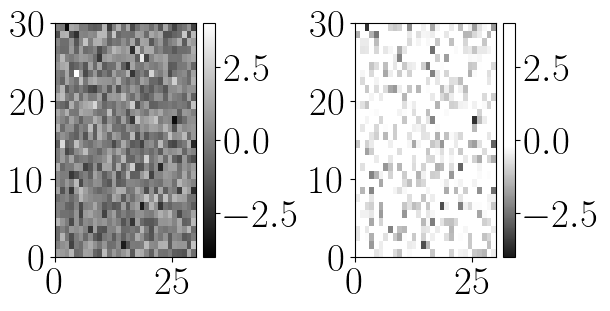

In [14]:
viridis = cm.get_cmap('gray', 256)
viridis_big = cm.get_cmap('gray')
newcmp = ListedColormap(viridis_big(np.linspace(0.1,2, 256)))
plot_examples([viridis, newcmp])

CPU times: user 4min 49s, sys: 20.8 s, total: 5min 10s
Wall time: 5min 5s


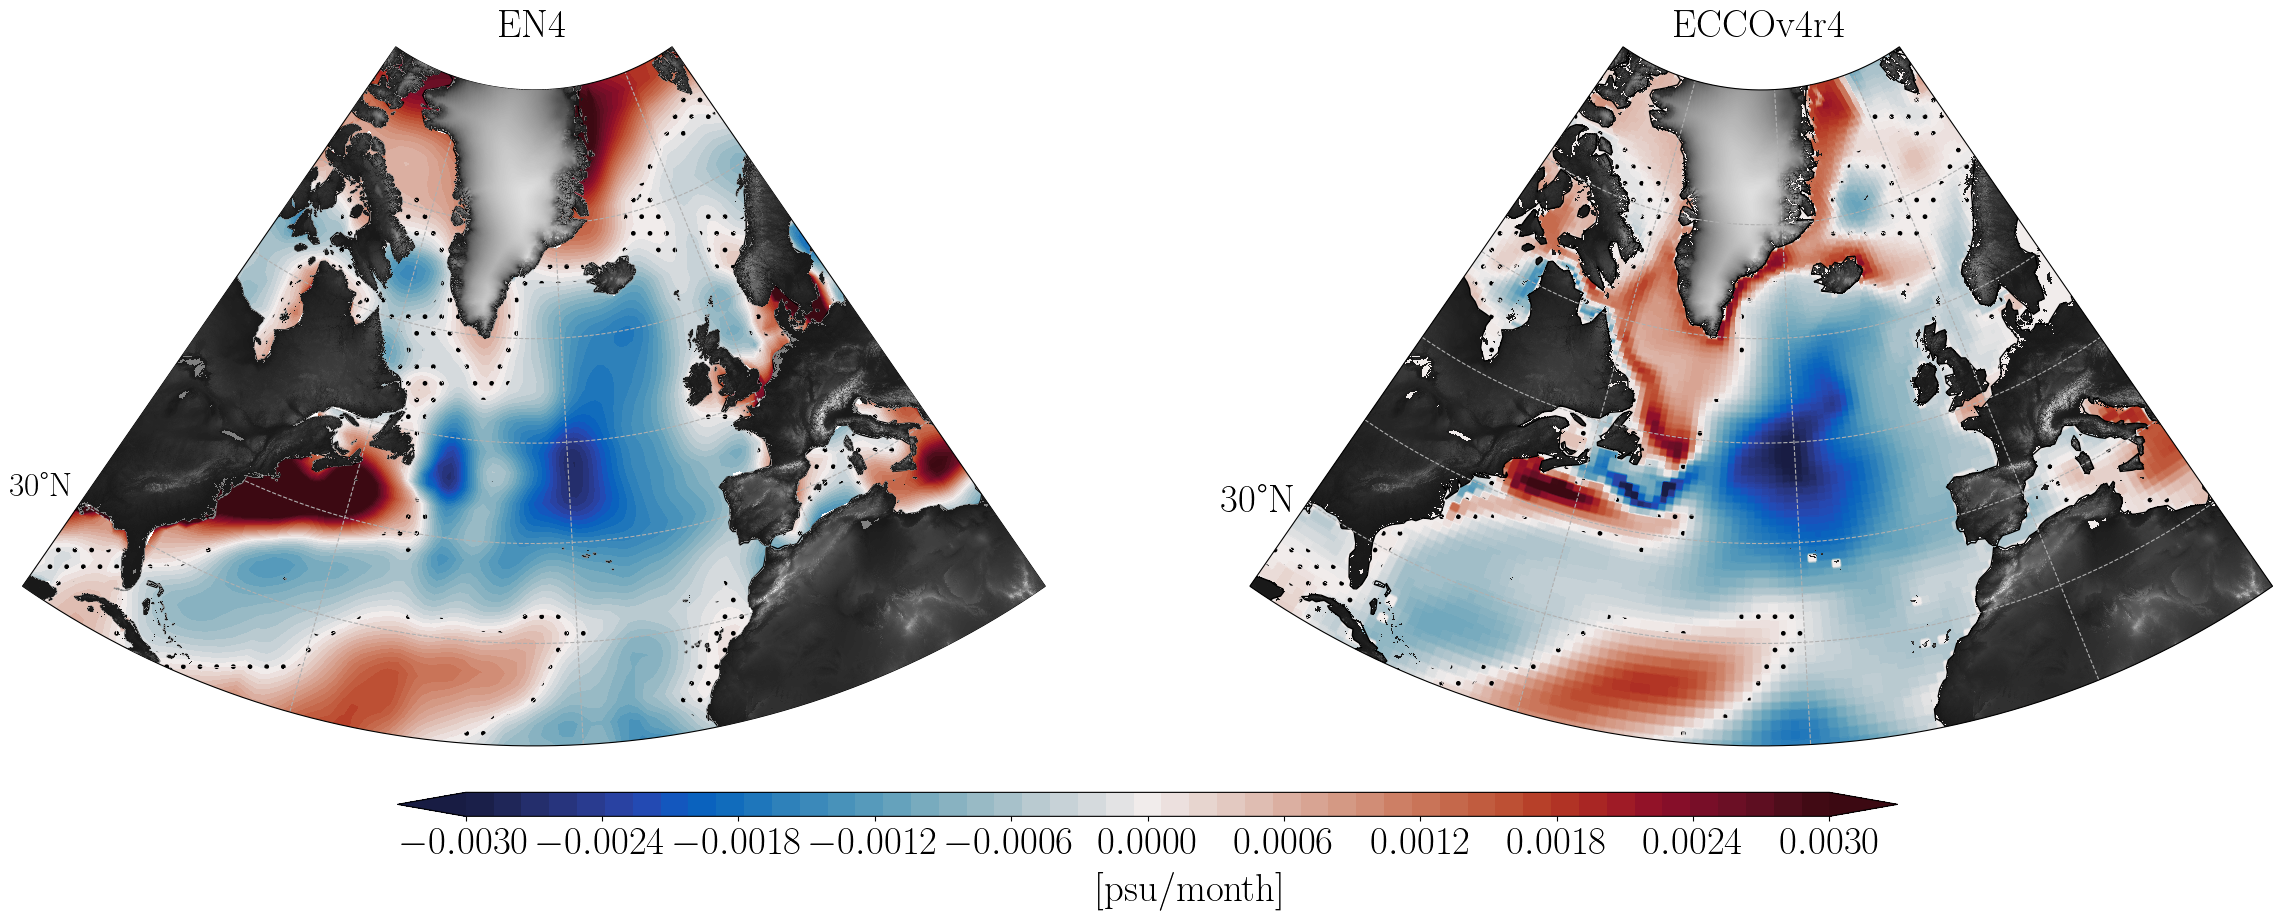

In [15]:
%%time

# fixed a plotting issue by bumping numpy to 1.22.0
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator


#fig= plt.figure(figsize=(10,10), frameon=True)

# defining the projection 
lon1, lon2, lat1, lat2 = [-90, 20, 20, 80]

rect = mpath.Path([[lon1, lat1], [lon2, lat1],
    [lon2, lat2], [lon1, lat2], [lon1, lat1]], closed=True).interpolated(150)

name='LambertConformal'
proj=ccrs.LambertConformal(central_longitude=(lon1+lon2)*0.5,
    central_latitude=(lat1+lat2)*0.5)


# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': proj},
                        figsize=(25,12))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()
                        
#ax = plt.axes(projection=proj)

                        
# defining levels for the pcolormesh
cmap = cmocean.cm.balance
levels = MaxNLocator(nbins=100).tick_values(-0.003,0.003)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)


# pcolormesh plot
im_en4 = axs[0].contourf(lons, f2_trend_en4.lat,data, cmap=cmocean.cm.balance,
           levels=np.linspace(-0.003, 0.003, 50), transform=ccrs.PlateCarree(), extend='both')
im_en4hatch = axs[0].contourf(f2_trend_en4.lon, f2_trend_en4.lat,f2_trend_en4.slope.where(f2_trend_en4.p_value>=0.05), cmap=cmocean.cm.balance,
           levels=np.linspace(-0.003, 0.003, 50), hatches='..',transform=ccrs.PlateCarree(), extend='both')

#Adding etopop
axs[0].pcolormesh(grid.x[::4], grid.y[::4], grid.z[::4,::4], transform=ccrs.PlateCarree(), cmap=newcmp, zorder=10)

# Title each subplot with the name of the model
#axs[i].set_title(str(i+1))

proj_to_data = ccrs.PlateCarree()._as_mpl_transform(axs[0]) - axs[0].transData
rect_in_target = proj_to_data.transform_path(rect)

axs[0].set_boundary(rect_in_target)
axs[0].set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
axs[0].set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())
axs[0].coastlines()
axs[0].add_feature(land_50m) 

gl=axs[0].gridlines(draw_labels=False, x_inline=False, y_inline=False, linestyle='dashed')
gl.top_labels=False
gl.right_labels=False
gl.left_labels=True
gl.bottom_labels=False
gl.rotate_labels=False
gl.xlocator=ctk.LongitudeLocator(4)
gl.ylocator=ctk.LatitudeLocator(6)
gl.xformatter=ctk.LongitudeFormatter(zero_direction_label=False)
gl.yformatter=ctk.LatitudeFormatter()
#gl.xlabel_style = {'size': 12, 'color': 'red', 'ha':'right', 'va':'top' ,'rotation':'10'}
gl.ylabel_style = {'size': 24, 'color': 'black', 'va': 'bottom', 'ha':'right'}




ds = f2_trend_ecco

dx=0.25
dy=0.25

# Extract LLC 2D coordinates
lons_1d = ds.XC.values.ravel()
lats_1d = ds.YC.values.ravel()

# Define original grid
orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

# Longitudes latitudes to which we will we interpolate
lon_tmp = np.arange(-180, 180, dx) + dx/2
lat_tmp = np.arange(-90, 90, dy) + dy/2

# Define the lat lon points of the two parts.
new_grid_lon, new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
new_grid  = pyresample.geometry.GridDefinition(lons=new_grid_lon,
                                                    lats=new_grid_lat)

da = ds.slope
       
field = pyresample.kd_tree.resample_nearest(orig_grid, da.values,
                                            new_grid,
                                            radius_of_influence=100000,
                                            fill_value=None)

f2_trend_masked = f2_trend_ecco.copy()
f2_trend_masked['slope'] = f2_trend_masked['slope'].where(f2_trend_masked.p_value>0.05)
        
field_masked = pyresample.kd_tree.resample_nearest(orig_grid, f2_trend_masked['slope'].values,
                                            new_grid,
                                            radius_of_influence=100000,
                                            fill_value=None)

vmax = -0.003
vmin = 0.003


x,y = new_grid_lon, new_grid_lat
lon_0=-40

# Find index where data is splitted for mapping
split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))

levels=np.linspace(-0.003, 0.003, 100)

p = axs[1].contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
                  transform=cart.crs.PlateCarree(), levels=levels,cmap=cmocean.cm.balance, 
                         extend='both')
p = axs[1].contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
                  transform=cart.crs.PlateCarree(), levels=levels,cmap=cmocean.cm.balance, 
                         extend='both')

p_hatch = axs[1].contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field_masked[:,:split_lon_idx],
                  hatches='..', transform=cart.crs.PlateCarree(), levels=levels,cmap=cmocean.cm.balance, 
                         extend='both')
p_hatch = axs[1].contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field_masked[:,split_lon_idx:],
                  hatches='..',transform=cart.crs.PlateCarree(), levels=levels,cmap=cmocean.cm.balance, 
                         extend='both')


proj_to_data = ccrs.PlateCarree()._as_mpl_transform(axs[1]) - axs[1].transData
rect_in_target = proj_to_data.transform_path(rect)

axs[1].set_boundary(rect_in_target)
axs[1].set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
axs[1].set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())
axs[1].coastlines()
#axs[1].add_feature(land_50m) 
#Adding etopop
axs[1].pcolormesh(grid.x[::4], grid.y[::4], grid.z[::4,::4], transform=ccrs.PlateCarree(), cmap=newcmp)

gl=axs[1].gridlines(draw_labels=False, x_inline=False, y_inline=False, linestyle='dashed')
gl.top_labels=False
gl.left_labels=True
gl.right_labels=False
gl.bottom_labels=False
gl.rotate_labels=False
gl.xlocator=ctk.LongitudeLocator(4)
gl.ylocator=ctk.LatitudeLocator(6)
gl.xformatter=ctk.LongitudeFormatter(zero_direction_label=False)
gl.yformatter=ctk.LatitudeFormatter()
#gl.xlabel_style = {'size': 12, 'color': 'red', 'ha':'right', 'va':'top' ,'rotation':'10'}
gl.ylabel_style = {'size': 28, 'color': 'black'}# 'va': 'bottom', 'ha':'right'}


# ds = f2_trend_aste

# dx=0.25
# dy=0.25

# # Extract LLC 2D coordinates
# lons_1d = ds.XC.values.ravel()
# lats_1d = ds.YC.values.ravel()

# # Define original grid
# orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

# # Longitudes latitudes to which we will we interpolate
# lon_tmp = np.arange(-180, 180, dx) + dx/2
# lat_tmp = np.arange(-90, 90, dy) + dy/2

# # Define the lat lon points of the two parts.
# new_grid_lon, new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
# new_grid  = pyresample.geometry.GridDefinition(lons=new_grid_lon,
#                                                     lats=new_grid_lat)

# da = ds.slope
       
# field = pyresample.kd_tree.resample_nearest(orig_grid, da.values,
#                                             new_grid,
#                                             radius_of_influence=100000,
#                                             fill_value=None)

# f2_trend_masked = f2_trend_aste.copy()
# f2_trend_masked['slope'] = f2_trend_masked['slope'].where(f2_trend_masked.p_value>0.05)
        
# field_masked = pyresample.kd_tree.resample_nearest(orig_grid, f2_trend_masked['slope'].values,
#                                             new_grid,
#                                             radius_of_influence=100000,
#                                             fill_value=None)

# vmax = -0.003
# vmin = 0.003


# x,y = new_grid_lon, new_grid_lat
# lon_0=-40

# # Find index where data is splitted for mapping
# split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))

# levels=np.linspace(-0.003, 0.003, 100)

# p = axs[2].contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
#                   transform=cart.crs.PlateCarree(), levels=levels,cmap=cmocean.cm.balance, 
#                          extend='both')
# p = axs[2].contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
#                   transform=cart.crs.PlateCarree(), levels=levels,cmap=cmocean.cm.balance, 
#                          extend='both')

# p_hatch = axs[2].contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field_masked[:,:split_lon_idx],
#                   hatches='..', transform=cart.crs.PlateCarree(), levels=levels,cmap=cmocean.cm.balance, 
#                          extend='both')
# p_hatch = axs[2].contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field_masked[:,split_lon_idx:],
#                   hatches='..',transform=cart.crs.PlateCarree(), levels=levels,cmap=cmocean.cm.balance, 
#                          extend='both')


# proj_to_data = ccrs.PlateCarree()._as_mpl_transform(axs[1]) - axs[1].transData
# rect_in_target = proj_to_data.transform_path(rect)

# axs[2].set_boundary(rect_in_target)
# axs[2].set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
# axs[2].set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())
# axs[2].coastlines()
# #axs[1].add_feature(land_50m) 
# #Adding etopop
# axs[2].pcolormesh(grid.x, grid.y, grid.z, transform=ccrs.PlateCarree(), cmap=newcmp)

# gl=axs[2].gridlines(draw_labels=True, x_inline=False, y_inline=False, linestyle='dashed')
# gl.top_labels=False
# gl.right_labels=False
# gl.bottom_labels=False
# gl.rotate_labels=False
# gl.xlocator=ctk.LongitudeLocator(4)
# gl.ylocator=ctk.LatitudeLocator(6)
# gl.xformatter=ctk.LongitudeFormatter(zero_direction_label=True)
# gl.yformatter=ctk.LatitudeFormatter()
# #gl.xlabel_style = {'size': 12, 'color': 'red', 'ha':'right', 'va':'top' ,'rotation':'10'}
# gl.ylabel_style = {'size': 20, 'color': 'black', 'va': 'bottom', 'ha':'right'}


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.2)  

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(im_en4, cax=cbar_ax,orientation='horizontal', ticks=np.linspace(-0.003,0.003,11), extend='both')
plt.figtext(0.48,0.13, r'[psu/month]', fontsize=28)
plt.figtext(0.24,0.85, r'EN4', fontweight='bold', fontsize=28)
plt.figtext(0.71,0.85, r'ECCOv4r4', fontsize=28)
# plt.figtext(0.8,0.85, r'ASTE\textunderscore R1', fontsize=20)

plt.savefig('figs/Fig_4.png', format='png', bbox_inches='tight', facecolor='w',dpi=300)    